In [1]:
fl_app = 'nvflare-sverepec_spolu-sim'
model_arch = 'myModel3'
model_name = 'model-simulate_job-1679485331.h5'
num_sites = 4

In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import tensorflow as tf

exec('import %s' % model_arch)

nvflare_app_dir = os.path.join('..', fl_app)
data_dir = os.path.join(nvflare_app_dir, 'data')
app_server_dir = os.path.join(nvflare_app_dir, 'workspace', 'simulate_job', 'app_server')

sys.path.append(nvflare_app_dir)

from IPython.display import JSON, HTML
from nvflare.fuel.utils import fobs
from nvflare.app_common.abstract.model import ModelLearnable, make_model_learnable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import trange, tqdm

np.set_printoptions(precision=2)
summary_line_length = 128

In [13]:
def print_cm(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='Blues',
        # square=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        # annot_kws={'size': 12}
    )

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    # plt.show()

## load global model

In [4]:
# model_filename = os.path.join(app_server_dir, 'model.h5')
model_filename = os.path.join('..', 'models', model_name)
m = tf.keras.models.load_model(model_filename)
m.summary(line_length=summary_line_length, expand_nested=True)

Model: "model_1000"
________________________________________________________________________________________________________________________________
 Layer (type)                                            Output Shape                                       Param #             
 input_1001 (InputLayer)                                 [(None, 186)]                                      0                   
                                                                                                                                
 fullyConnectedLayer1_ (Dense)                           (None, 28)                                         5236                
                                                                                                                                
 batchNormalizationLayer_ (BatchNormalization)           (None, 28)                                         112                 
                                                                             

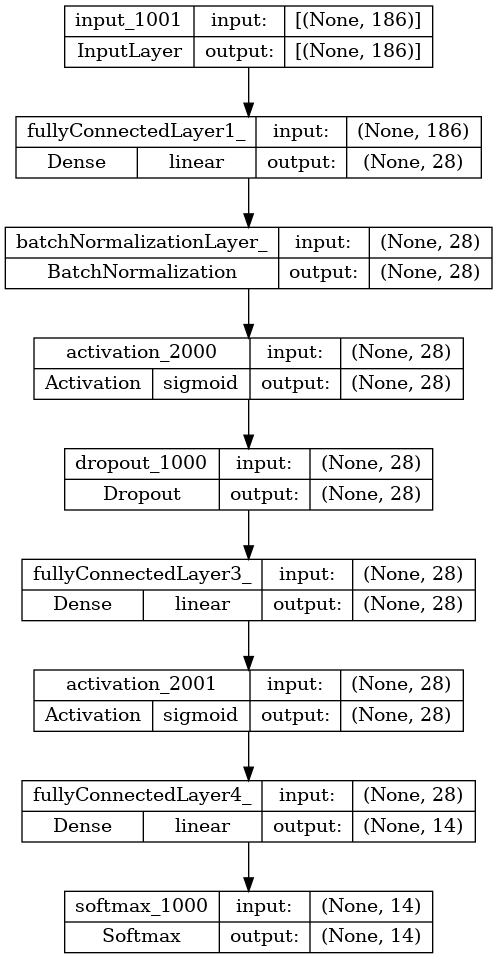

In [5]:
tf.keras.utils.plot_model(
    m,
    expand_nested=True,
    show_shapes=True,
    show_layer_activations=True
)

## load label encoder

In [6]:
label_encoder_filename = os.path.join(data_dir, 'encoder-DRUH_DR.npy')
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load(label_encoder_filename, allow_pickle=True)

## load all-site validation data

In [7]:
df = pd.DataFrame()

for site in trange(1, num_sites + 1):
    filename_test = os.path.join(data_dir, 'site-%s' % site, 'test.csv')
    df_test = pd.read_csv(filename_test)
    df = pd.concat([df, df_test])

X = df[df.columns.drop(df.DRUH_DR.name)]
Y = df[df.DRUH_DR.name]
Y = label_encoder.inverse_transform(Y)
Y = pd.DataFrame(Y, columns=['Y'])

  0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
def predict_model(m, X, Y, label_encoder):
    Y_pred = m.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_pred = label_encoder.inverse_transform(Y_pred)
    Y_pred = pd.DataFrame(Y_pred, columns=['Y_pred'])
    return Y_pred

## test global model

317/317 [==============================] - 1s 3ms/step


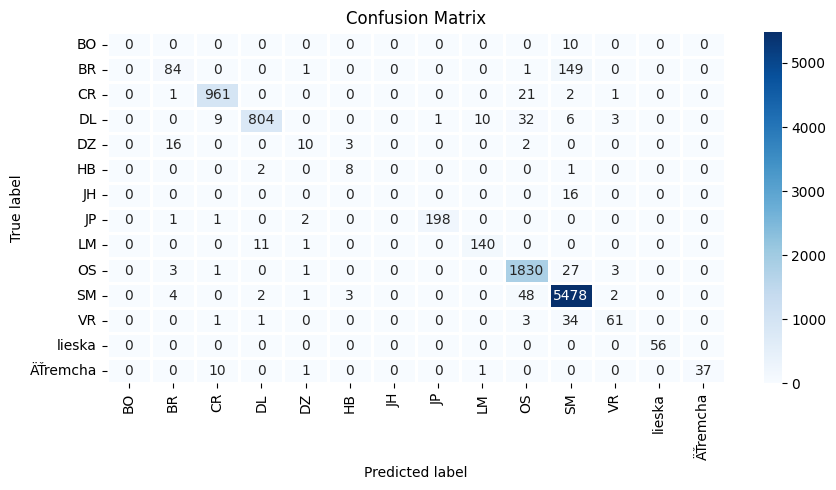

In [9]:
Y_pred = predict_model(m, X, Y, label_encoder=label_encoder)
cm = confusion_matrix(Y, Y_pred)

fig, ax = plt.subplots(figsize=(9,5))
print_cm(ax, cm, labels=label_encoder.classes_)
plt.show()

317/317 [==============================] - 1s 2ms/step


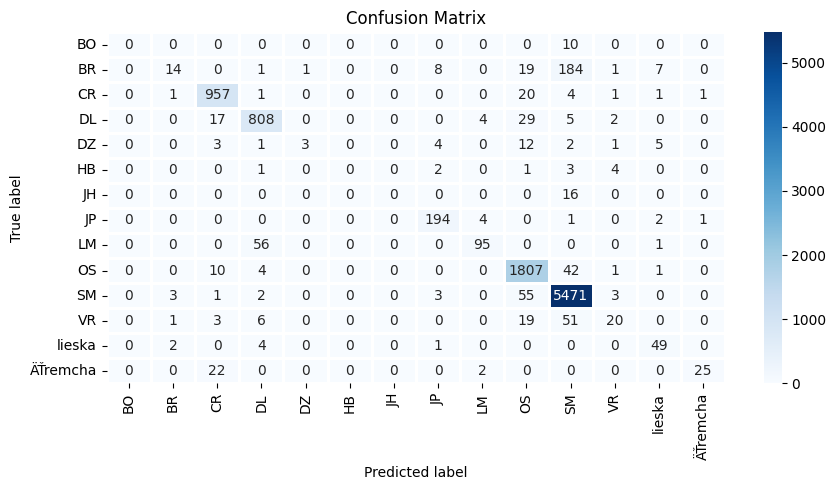

In [10]:
m_pk = myModel3.load_model()

Y_pred_pk = predict_model(m_pk, X, Y, label_encoder=label_encoder)
cm_pk = confusion_matrix(Y, Y_pred_pk)

fig, ax = plt.subplots(figsize=(9,5))
print_cm(ax, cm_pk, labels=label_encoder.classes_)
plt.show()

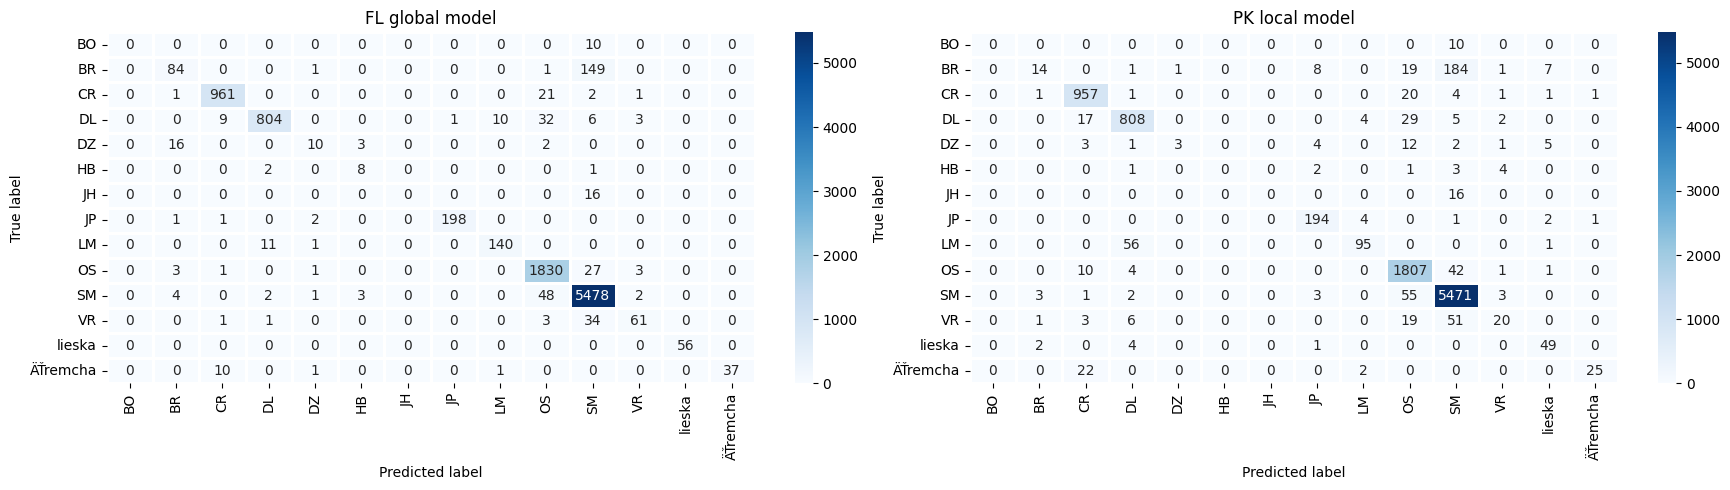

In [16]:
fig, axs = plt.subplots(1,2, figsize=(18,5))
print_cm(axs[1], cm_pk, title='PK local model', labels=label_encoder.classes_)
print_cm(axs[0], cm, title='FL global model', labels=label_encoder.classes_)
plt.show()

In [ ]:
# conf_matrix = pd.DataFrame(cm)
# conf_matrix.rename(columns=lambda x: label_encoder.inverse_transform([x])[0], inplace=True)
# conf_matrix.rename(index=lambda x: label_encoder.inverse_transform([x])[0], inplace=True)
# conf_matrix.set_index(pd.MultiIndex.from_product([['truth'], conf_matrix.index]), inplace=True)
# conf_matrix.columns = pd.MultiIndex.from_product([['prediction'], conf_matrix.columns])
# conf_matrix
# conf_matrix.to_excel('model-simulate_job-1679485331-confusion_matrix-test_data.xlsx')